In [26]:
import numpy as np
from PIL import Image
import os
from model import *
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image, ImageDraw
from matplotlib.animation import FuncAnimation
from util.stroke_plotting import animate_word, plot_word_strokes
from util.visualize_progress import get_strokes_from_model_output
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024

In [3]:
# resize image to a fixed height
def resize_image(image, required_height):
    image_size = np.array(image).shape
    height, width = image_size[0], image_size[1]
    scale_factor = required_height / height
    width = int(width * scale_factor)
    resized_image = image.resize((width, required_height))
    return resized_image

In [48]:
def create_list(output_folder_path):
    width_list = []
    image_list = []
    for files in os.listdir(output_folder_path):
        if files.endswith(('.jpg', '.jpeg', '.png')):
            image_path = output_folder_path + files
            image = Image.open(image_path)
            image = image.convert('L')
            image_size = np.array(image).shape
            if image_size[0]!=img_height:
                image = resize_image(image, img_height)
            image = np.array(image)
            image_size = np.array(image).shape
            height, width = image_size[0], image_size[1]
            # store width of each image in a list
            width_list.append(width)
            # store image in a list
            image_list.append(image)
    return width_list, image_list

In [55]:
def load_model(model_name, model_path):
    model = model_name
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

In [39]:
def forward_pass(model, image_list, width_list, space_bn_words):
    stroke_array = []
    for i in range(len(image_list)):
        image = image_list[i]
        width = width_list[i]
        # convert image to tensor
        image = transforms.ToTensor()(image)
        image = image.unsqueeze(0)
        # run forward pass
        output = model(image)
        # convert output to numpy array
        output = get_strokes_from_model_output(output.squeeze(0))
        stroke_array.append(output)
    return stroke_array

In [66]:
def translate_strokes(strokes, page_width, width_list, space_bn_words):
    lines = []
    line = []

    current_width = 0
    max_x_stroke = 0
    line_height = 57  # initial line height
    for stroke, width in zip(strokes, width_list):
        if current_width + width + space_bn_words > page_width:
            # move to next line
            lines.append(np.concatenate(line, axis=0))
            max_x_stroke = 0  # reset max_x_stroke to 0
            current_width = 0  # reset current_width to 0
            line_height += 60  # increase line height
            line = []

        # add to current line
        # translate it to max_x_stroke of previous word + space_bn_words
        stroke[:, 0] += max_x_stroke + space_bn_words
        # translate y coordinate to line_height
        stroke[:, 1] += line_height - np.max(stroke[:, 1])
        line.append(stroke)
        current_width += width + space_bn_words
        max_x_stroke += width + space_bn_words

    # add the last line
    if line:
        lines.append(np.concatenate(line, axis=0))
    lines = np.concatenate(lines, axis=0)
    # animate_word(lines, speed=0.2, save_path='animation1.gif')
    np.save('../STR_model/model_output_gif/Line_Strokes/line_strokes.npy', lines)
    return lines

In [61]:
def get_animation(img_folder_path, model, page_width, space_bn_words, animation_path):
    width_list, image_list = create_list(img_folder_path)
    stroke_array = forward_pass(model, image_list, width_list, space_bn_words)
    strokes_array = translate_strokes(stroke_array, page_width, width_list, space_bn_words)
    plot_word_strokes(strokes_array)
    lines = translate_strokes(stroke_array, page_width, width_list, space_bn_words)
    animate_word(lines, speed=0.2, save_path=animation_path)

In [56]:
# load model
model_name = STR_Model_Longer_1024()
model_path = '../STR_model/STR_Model_Longer_1024_Relative_DTW_20_4.pth'
model = load_model(model_name, model_path)

In [63]:
# parameters 
page_width = 500  # can be changed
space_bn_words = 20  # can be changed
img_height = 60 

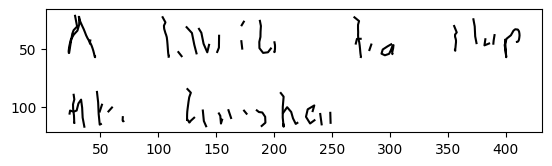

In [65]:
# path to folder containing images
img_folder_path = '../../DataSet/IAM-Online/test_str_model/Images/'
# path to save animation
animation_path = '../STR_model/model_output_gif/animation3.gif'
get_animation(img_folder_path, model, page_width, space_bn_words, animation_path)

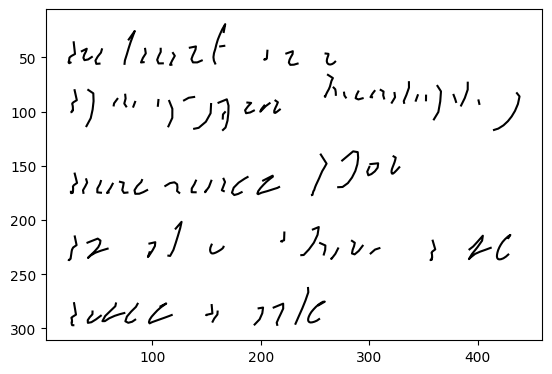

In [64]:
# path to folder containing images
img_folder_path = '../../DataSet/internet/'
# path to save animation
animation_path = '../STR_model/model_output_gif/animation2.gif'
get_animation(img_folder_path, model, page_width, space_bn_words, animation_path)

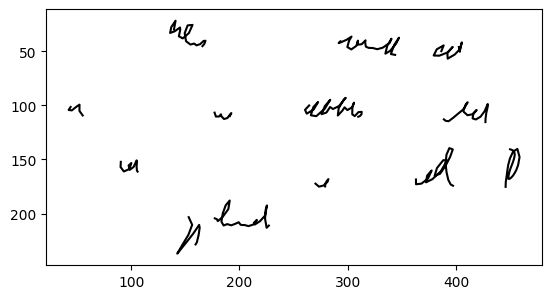

In [67]:
# path to folder containing images
img_folder_path = '../HWT-model/demo_output/writer_Anita/'
# path to save animation
animation_path = '../STR_model/model_output_gif/animation1.gif'
get_animation(img_folder_path, model, page_width, space_bn_words, animation_path)